### NSGA 2

In [7]:
import numpy as np
from typing import List, Tuple

class NSGA2:
    """
    Represents a solution in the NSGA-II algorithm.
    """
    def __init__(self, x: np.ndarray):
        self.x = x  # Decision variables
        self.objectives = None  # Objective function values
        self.rank = None  # Non-domination rank
        self.crowding_distance = None  # Crowding distance

def generate_initial_population(pop_size: int, n_vars: int) -> List[NSGA2]:
    """
    Generate an initial population of random solutions.
    
    :param pop_size: Number of solutions in the population
    :param n_vars: Number of decision variables
    :return: List of initial solutions
    """
    return [NSGA2(np.random.random(n_vars)) for _ in range(pop_size)]

def evaluate_objectives(population: List[NSGA2], objective_functions: List[callable]):
    """
    Evaluate the objective functions for each solution in the population.
    
    :param population: List of solutions
    :param objective_functions: List of objective functions to evaluate
    """
    for solution in population:
        solution.objectives = [float(f(solution.x)) for f in objective_functions]

def dominates(p: NSGA2, q: NSGA2) -> bool:
    """
    Check if solution p dominates solution q.
    
    :param p: First solution
    :param q: Second solution
    :return: True if p dominates q, False otherwise
    """
    return all(p_obj <= q_obj for p_obj, q_obj in zip(p.objectives, q.objectives)) and \
           any(p_obj < q_obj for p_obj, q_obj in zip(p.objectives, q.objectives))

def non_dominated_sort(population: List[NSGA2]):
    """
    Perform non-dominated sorting on the population.
    
    This function assigns a rank to each solution based on non-domination.
    Rank 1 solutions are non-dominated, rank 2 are dominated only by rank 1, etc.
    """
    for p in population:
        p.domination_count = 0
        p.dominated_solutions = []
        
        for q in population:
            if dominates(p, q):
                p.dominated_solutions.append(q)
            elif dominates(q, p):
                p.domination_count += 1
        
        if p.domination_count == 0:
            p.rank = 1
    
    front = 1
    while True:
        current_front = [p for p in population if p.rank == front]
        if not current_front:
            break
        
        for p in current_front:
            for q in p.dominated_solutions:
                q.domination_count -= 1
                if q.domination_count == 0:
                    q.rank = front + 1
        
        front += 1

def calculate_crowding_distance(population: List[NSGA2]):
    """
    Calculate crowding distance for each solution in the population.
    
    Crowding distance is a measure of how close a solution is to its neighbors.
    It's used to maintain diversity in the population.
    """
    for front in set(s.rank for s in population):
        front_solutions = [s for s in population if s.rank == front]
        if len(front_solutions) <= 2:
            for s in front_solutions:
                s.crowding_distance = float('inf')
            continue
        
        num_objectives = len(front_solutions[0].objectives)
        for i in range(num_objectives):
            front_solutions.sort(key=lambda x: x.objectives[i])
            front_solutions[0].crowding_distance = front_solutions[-1].crowding_distance = float('inf')
            
            for j in range(1, len(front_solutions) - 1):
                if front_solutions[-1].objectives[i] == front_solutions[0].objectives[i]:
                    front_solutions[j].crowding_distance = 0
                else:
                    front_solutions[j].crowding_distance = (front_solutions[j+1].objectives[i] - front_solutions[j-1].objectives[i]) / \
                                                           (front_solutions[-1].objectives[i] - front_solutions[0].objectives[i])
        
        for s in front_solutions:
            if s.crowding_distance is None:
                s.crowding_distance = 0
            else:
                s.crowding_distance += s.crowding_distance

def tournament_selection(population: List[NSGA2], tournament_size: int) -> NSGA2:
    """
    Perform tournament selection to choose a parent.
    
    :param population: List of solutions
    :param tournament_size: Number of solutions in each tournament
    :return: Selected solution
    """
    tournament = np.random.choice(population, tournament_size, replace=False)
    return min(tournament, key=lambda x: (x.rank, -(x.crowding_distance or 0)))

def crossover(parent1: NSGA2, parent2: NSGA2, crossover_rate: float) -> Tuple[NSGA2, NSGA2]:
    """
    Perform crossover between two parents to create two children.
    
    :param parent1: First parent solution
    :param parent2: Second parent solution
    :param crossover_rate: Probability of crossover
    :return: Two child solutions
    """
    if np.random.random() < crossover_rate:
        alpha = np.random.random(len(parent1.x))
        child1 = NSGA2(alpha * parent1.x + (1 - alpha) * parent2.x)
        child2 = NSGA2((1 - alpha) * parent1.x + alpha * parent2.x)
        return child1, child2
    return parent1, parent2

def mutation(solution: NSGA2, mutation_rate: float):
    """
    Perform mutation on a solution.
    
    :param solution: Solution to mutate
    :param mutation_rate: Probability of mutation for each decision variable
    """
    mask = np.random.random(len(solution.x)) < mutation_rate
    solution.x[mask] = np.random.random(mask.sum())

def nsga_ii(pop_size: int, n_vars: int, n_generations: int, objective_functions: List[callable],
            crossover_rate: float, mutation_rate: float):
    """
    Main NSGA-II algorithm.
    
    :param pop_size: Population size
    :param n_vars: Number of decision variables
    :param n_generations: Number of generations
    :param objective_functions: List of objective functions
    :param crossover_rate: Crossover rate
    :param mutation_rate: Mutation rate
    :return: Final population
    """
    # Initialize population
    population = generate_initial_population(pop_size, n_vars)
    
    for generation in range(n_generations):
        # Evaluate objectives
        evaluate_objectives(population, objective_functions)
        
        # Perform non-dominated sorting
        non_dominated_sort(population)
        
        # Calculate crowding distance
        calculate_crowding_distance(population)
        
        # Create offspring through selection, crossover, and mutation
        offspring = []
        while len(offspring) < pop_size:
            parent1 = tournament_selection(population, 2)
            parent2 = tournament_selection(population, 2)
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            mutation(child1, mutation_rate)
            mutation(child2, mutation_rate)
            offspring.extend([child1, child2])
        
        # Combine parent and offspring populations
        population.extend(offspring)
        
        # Evaluate objectives for the combined population
        evaluate_objectives(population, objective_functions)
        
        # Perform non-dominated sorting on the combined population
        non_dominated_sort(population)
        
        # Calculate crowding distance for the combined population
        calculate_crowding_distance(population)
        
        # Select the best solutions for the next generation
        new_population = []
        front = 1
        while len(new_population) + len([p for p in population if p.rank == front]) <= pop_size:
            current_front = [p for p in population if p.rank == front]
            new_population.extend(current_front)
            front += 1
        
        if len(new_population) < pop_size:
            last_front = [p for p in population if p.rank == front]
            last_front.sort(key=lambda x: -x.crowding_distance)
            new_population.extend(last_front[:pop_size - len(new_population)])
        
        population = new_population
    
    return population

# Example usage
def objective1(x):
    return np.sum(x**2)

def objective2(x):
    return np.sum((x - 2)**2)

pop_size = 100
n_vars = 10
n_generations = 100
objective_functions = [objective1, objective2]
crossover_rate = 0.9
mutation_rate = 0.1

final_population = nsga_ii(pop_size, n_vars, n_generations, objective_functions, crossover_rate, mutation_rate)

# Print the Pareto front
pareto_front = [p for p in final_population if p.rank == 1]
for solution in pareto_front:
    print(f"Objectives: {solution.objectives}")

Objectives: [5.571695485809531, 15.932264739768785]
Objectives: [1.2273575963936565, 27.36631987626867]
Objectives: [1.3475624953206649, 26.810491083690913]
Objectives: [4.4419710881663494, 17.83132582126362]
Objectives: [4.4419710881663494, 17.83132582126362]
Objectives: [3.0099915651320956, 21.112882708859708]
Objectives: [3.0099915651320956, 21.112882708859708]
Objectives: [3.770078781391825, 19.23200331625991]
Objectives: [1.3203032678675986, 27.005049122552208]
Objectives: [5.339064029352971, 16.269787817364577]
Objectives: [3.1969670784163178, 20.80892111814519]
Objectives: [4.195762641991374, 18.294263363063198]
Objectives: [5.03152659095802, 16.770857550406653]
Objectives: [1.401969452250763, 26.49596819201281]
Objectives: [4.1282213599515725, 18.596586853111255]
Objectives: [3.264165255235752, 20.472342536065618]
Objectives: [1.7796074059783469, 24.95395165222942]
Objectives: [4.922548318679384, 17.0391918930618]
Objectives: [4.552323762153514, 17.73435561229598]
Objectives: [

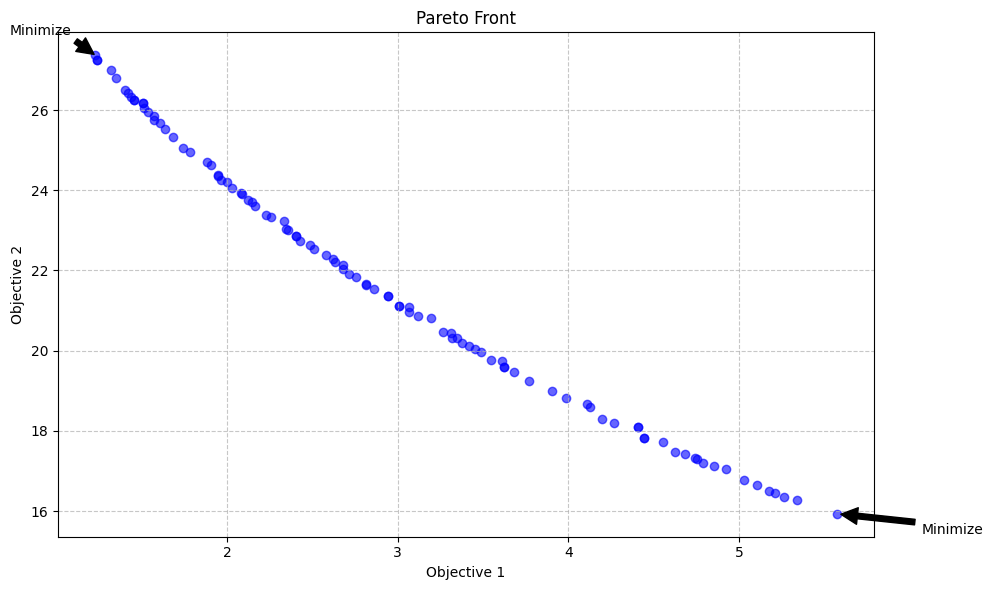

In [8]:
import matplotlib.pyplot as plt

# Assuming pareto_front is already defined
x = [solution.objectives[0] for solution in pareto_front]
y = [solution.objectives[1] for solution in pareto_front]

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c='blue', alpha=0.6)
plt.title('Pareto Front')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.annotate('Minimize', xy=(min(x), max(y)), xytext=(min(x)-0.5, max(y)+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Minimize', xy=(max(x), min(y)), xytext=(max(x)+0.5, min(y)-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

### Representation

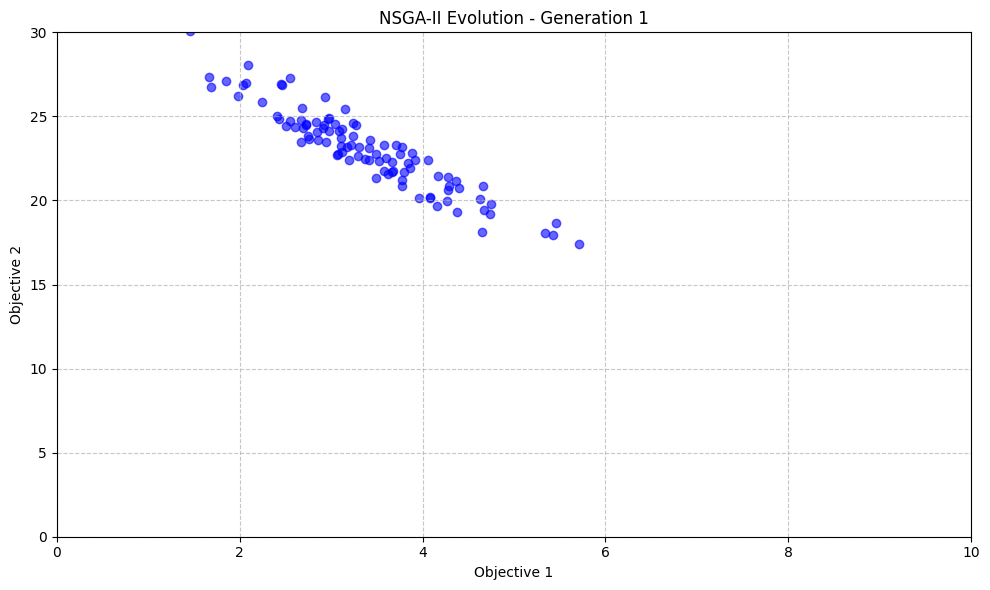

Final Pareto Front:
Objectives: [np.float64(6.5858010311140145), np.float64(14.332287566610972)]
Objectives: [np.float64(0.6645548125342364), np.float64(30.717671531084516)]
Objectives: [np.float64(0.8665261086622981), np.float64(29.550163854162207)]
Objectives: [np.float64(6.226236219048482), np.float64(14.88577731159413)]
Objectives: [np.float64(6.443701583043754), np.float64(14.602686539985402)]
Objectives: [np.float64(1.0904346030747565), np.float64(28.003115219281224)]
Objectives: [np.float64(0.9711528592636611), np.float64(28.627563712693075)]
Objectives: [np.float64(2.215578182433566), np.float64(23.485286093715665)]
Objectives: [np.float64(0.9222356650614363), np.float64(28.933635523478674)]
Objectives: [np.float64(5.669497725830908), np.float64(15.662845261207465)]
Objectives: [np.float64(2.927121872652128), np.float64(21.45878924122266)]
Objectives: [np.float64(1.1994758755927066), np.float64(27.385007366383732)]
Objectives: [np.float64(1.3819214574451681), np.float64(26.6430

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Solution:
    def __init__(self, x):
        self.x = x
        self.objectives = None
        self.rank = None
        self.crowding_distance = None

class NSGA2:
    def __init__(self, pop_size, n_vars, n_generations, objective_functions, crossover_rate, mutation_rate):
        self.pop_size = pop_size
        self.n_vars = n_vars
        self.n_generations = n_generations
        self.objective_functions = objective_functions
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.population_history = []

    def initialize_population(self):
        return [Solution(np.random.random(self.n_vars)) for _ in range(self.pop_size)]

    def evaluate_objectives(self, population):
        for solution in population:
            solution.objectives = [f(solution.x) for f in self.objective_functions]

    def dominates(self, p, q):
        return all(p_obj <= q_obj for p_obj, q_obj in zip(p.objectives, q.objectives)) and \
               any(p_obj < q_obj for p_obj, q_obj in zip(p.objectives, q.objectives))

    def non_dominated_sort(self, population):
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = []
            for q in population:
                if self.dominates(p, q):
                    p.dominated_solutions.append(q)
                elif self.dominates(q, p):
                    p.domination_count += 1
            if p.domination_count == 0:
                p.rank = 1

        front = 1
        while True:
            current_front = [p for p in population if p.rank == front]
            if not current_front:
                break
            for p in current_front:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = front + 1
            front += 1

    def calculate_crowding_distance(self, population):
        for p in population:
            p.crowding_distance = 0

        for obj in range(len(self.objective_functions)):
            population.sort(key=lambda x: x.objectives[obj])
            population[0].crowding_distance = population[-1].crowding_distance = float('inf')
            obj_range = population[-1].objectives[obj] - population[0].objectives[obj]
            if obj_range == 0:
                continue
            for i in range(1, len(population) - 1):
                population[i].crowding_distance += (population[i+1].objectives[obj] - population[i-1].objectives[obj]) / obj_range

    def tournament_selection(self, population):
        participants = np.random.choice(population, 2, replace=False)
        return min(participants, key=lambda x: (x.rank, -x.crowding_distance))

    def crossover(self, parent1, parent2):
        if np.random.random() < self.crossover_rate:
            alpha = np.random.random(self.n_vars)
            child1 = Solution(alpha * parent1.x + (1 - alpha) * parent2.x)
            child2 = Solution((1 - alpha) * parent1.x + alpha * parent2.x)
            return child1, child2
        return parent1, parent2

    def mutation(self, solution):
        for i in range(self.n_vars):
            if np.random.random() < self.mutation_rate:
                solution.x[i] = np.random.random()

    def create_offspring(self, population):
        offspring = []
        while len(offspring) < self.pop_size:
            parent1 = self.tournament_selection(population)
            parent2 = self.tournament_selection(population)
            child1, child2 = self.crossover(parent1, parent2)
            self.mutation(child1)
            self.mutation(child2)
            offspring.extend([child1, child2])
        return offspring[:self.pop_size]

    def select_next_generation(self, population, offspring):
        combined = population + offspring
        self.non_dominated_sort(combined)
        self.calculate_crowding_distance(combined)
        combined.sort(key=lambda x: (x.rank, -x.crowding_distance))
        return combined[:self.pop_size]

    def run(self):
        population = self.initialize_population()
        for generation in range(self.n_generations):
            self.evaluate_objectives(population)
            self.non_dominated_sort(population)
            self.calculate_crowding_distance(population)
            self.population_history.append(population.copy())
            
            offspring = self.create_offspring(population)
            self.evaluate_objectives(offspring)
            population = self.select_next_generation(population, offspring)

        return population

# Define objective functions
def objective1(x):
    return np.sum(x**2)

def objective2(x):
    return np.sum((x - 2)**2)

# Create an instance of NSGA2 and run it
nsga2 = NSGA2(pop_size=100, n_vars=10, n_generations=50,
              objective_functions=[objective1, objective2],
              crossover_rate=0.9, mutation_rate=0.1)
final_population = nsga2.run()

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter([], [], c='blue', alpha=0.6)
ax.set_xlim(0, 10)  # Adjust these limits based on your objective ranges
ax.set_ylim(0, 30)
ax.set_title('NSGA-II Evolution')
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.grid(True, linestyle='--', alpha=0.7)

# Animation update function
def update(frame):
    population = nsga2.population_history[frame]
    x = [solution.objectives[0] for solution in population]
    y = [solution.objectives[1] for solution in population]
    scatter.set_offsets(np.c_[x, y])
    ax.set_title(f'NSGA-II Evolution - Generation {frame+1}')
    return scatter,

# Create the animation
anim = FuncAnimation(fig, update, frames=len(nsga2.population_history), 
                     interval=200, blit=True, repeat=False)

plt.tight_layout()
plt.show()

# Optionally, save the animation
anim.save('nsga2_evolution.gif', writer='pillow', fps=5)

# Print final Pareto front
pareto_front = [p for p in final_population if p.rank == 1]
print("Final Pareto Front:")
for solution in pareto_front:
    print(f"Objectives: {solution.objectives}")